In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


超额净值曲线

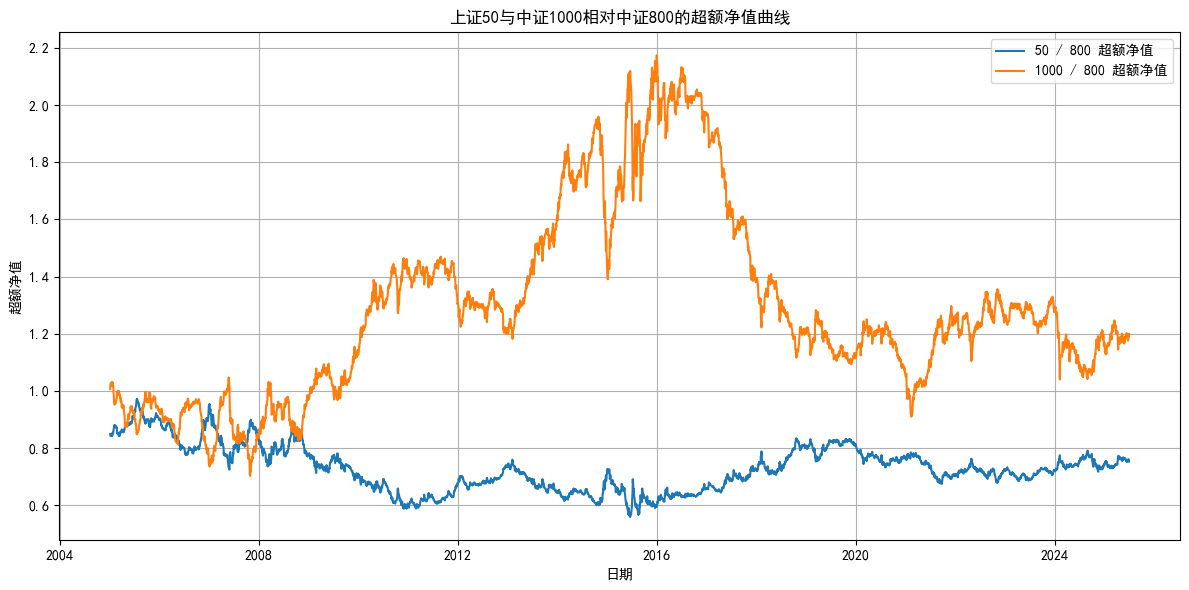

In [5]:
# 计算超额净值曲线
df['50_over_800'] = df['50收益'] / df['800收益']
df['1000_over_800'] = df['中证1000全收益'] / df['800收益']

# 画图
plt.figure(figsize=(12,6))
plt.plot(df.index, df['50_over_800'], label='50 / 800 超额净值')
plt.plot(df.index, df['1000_over_800'], label='1000 / 800 超额净值')

# 图表美化
plt.title('上证50与中证1000相对中证800的超额净值曲线')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 动量策略

### 动量基准策略

In [89]:
def momentum_strategy_monthly(df, window=10, threshold=0, min_large_weight=0.5):
    """
    纯动量大小盘切换策略（月度调仓版本）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算动量的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算动量 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            if (r_1000.loc[date] > r_50.loc[date] + threshold):
                current_pos_50 = 0
                current_pos_1000 = 1
            else:
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df


回测

In [90]:
# 获取策略每日仓位
position_df = momentum_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 19.64%
年化波动率: 27.42%
夏普比率: 0.72
最大回撤: -63.30%
Calmar Ratio: 0.31


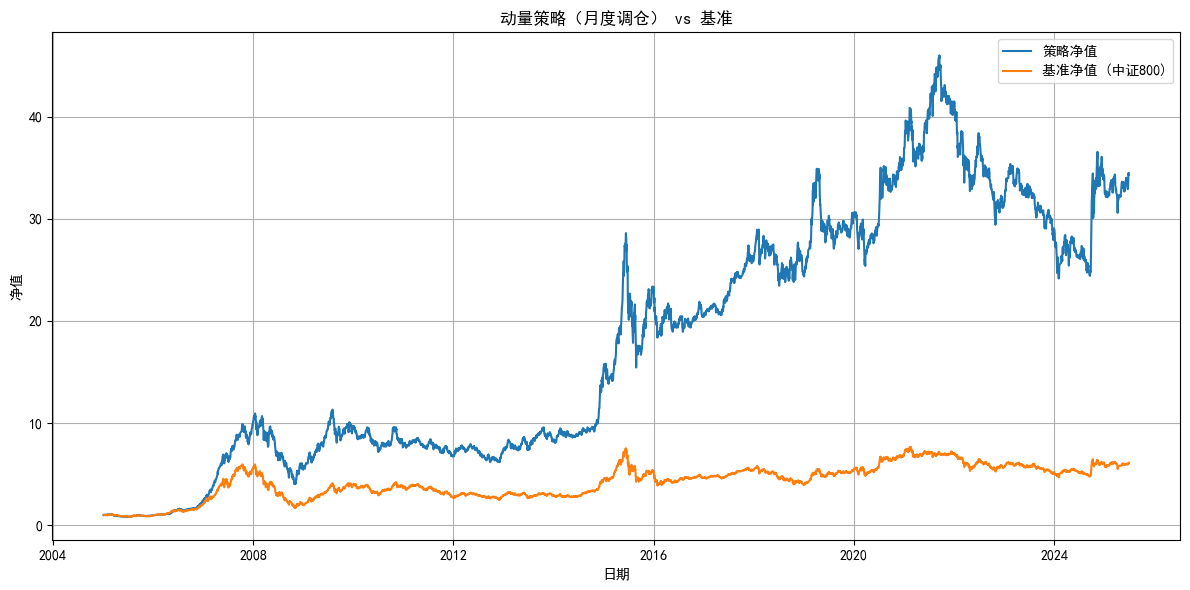

In [91]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

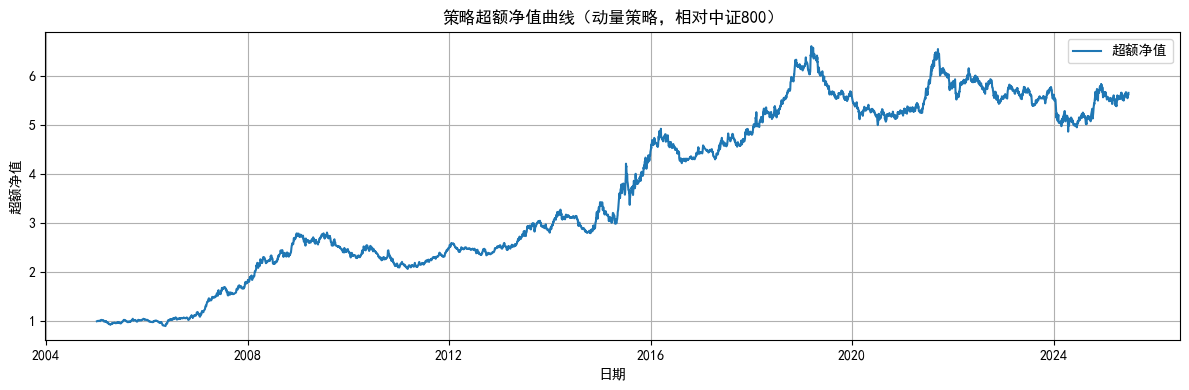

In [92]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（动量策略，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

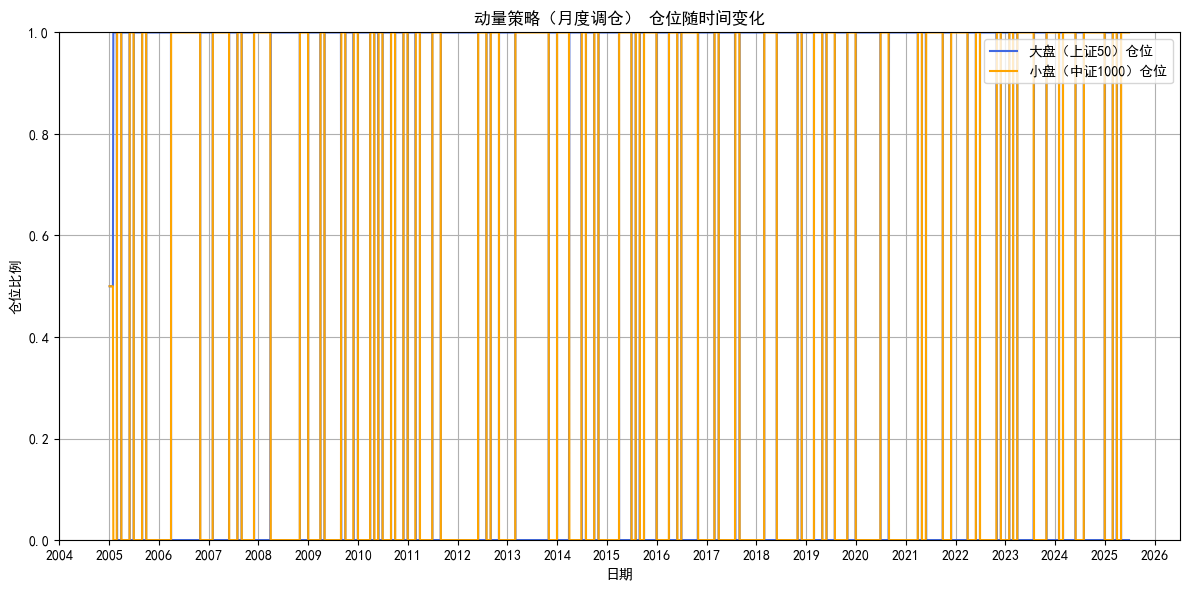

In [93]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

参数优化

In [94]:
# 数据切分

# 前80%作为训练集，后20%作为测试集
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

#在测试集上进行网格搜索
window_range = [10, 20, 30, 40, 50, 60]
threshold_range = [0.0, 0.005, 0.01, 0.015, 0.02]
min_large_weight_range = [0.5, 0.6, 0.7, 0.8, 0.9]

results = []

for window, threshold, min_large_weight in itertools.product(window_range, threshold_range, min_large_weight_range):
    
    # 获取策略仓位（在训练集上）
    position_df = momentum_strategy_monthly(df_train, window=window, threshold=threshold, min_large_weight=min_large_weight)
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'threshold': threshold,
        'min_large_weight': min_large_weight,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))


【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
   window  threshold  min_large_weight  annual_return  annual_vol  \
9      10      0.005               0.9       0.272105    0.285454   
8      10      0.005               0.8       0.271951    0.285460   
7      10      0.005               0.7       0.271794    0.285470   
6      10      0.005               0.6       0.271637    0.285485   
5      10      0.005               0.5       0.271477    0.285504   
4      10      0.000               0.9       0.257490    0.287107   
3      10      0.000               0.8       0.257337    0.287113   
2      10      0.000               0.7       0.257183    0.287123   
1      10      0.000               0.6       0.257027    0.287137   
0      10      0.000               0.5       0.256869    0.287156   

   sharpe_ratio  max_drawdown  calmar_ratio  
9      0.953237      -0.63305      0.429833  
8      0.952676      -0.63305      0.429588  
7      0.952094      -0.63305      0.429342  
6      0.951492     

三段划分数据

In [95]:
# 计算切分索引
split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

# 切分数据
df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

In [96]:
#在测试集上进行网格搜索
window_range = [10, 20, 30, 40, 50, 60]
threshold_range = [0.0, 0.005, 0.01, 0.015, 0.02]
min_large_weight_range = [0.5, 0.6, 0.7, 0.8, 0.9]

results = []

for window, threshold, min_large_weight in itertools.product(window_range, threshold_range, min_large_weight_range):
    
    # 获取策略仓位（在训练集上）
    position_df = momentum_strategy_monthly(df_train, window=window, threshold=threshold, min_large_weight=min_large_weight)
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'threshold': threshold,
        'min_large_weight': min_large_weight,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
   window  threshold  min_large_weight  annual_return  annual_vol  \
9      10      0.005               0.9       0.301890    0.297995   
8      10      0.005               0.8       0.301696    0.298002   
7      10      0.005               0.7       0.301499    0.298015   
6      10      0.005               0.6       0.301300    0.298032   
5      10      0.005               0.5       0.301099    0.298055   
4      10      0.000               0.9       0.293552    0.299263   
3      10      0.000               0.8       0.293358    0.299270   
2      10      0.000               0.7       0.293163    0.299283   
1      10      0.000               0.6       0.292965    0.299300   
0      10      0.000               0.5       0.292766    0.299322   

   sharpe_ratio  max_drawdown  calmar_ratio  
9      1.013071      -0.63305      0.476883  
8      1.012393      -0.63305      0.476575  
7      1.011691      -0.63305      0.476264  
6      1.010965     

测试最优参数

In [97]:
# 选取最优参数
best_params = results_df_sorted.iloc[0]

# 在测试集上运行策略
position_test = momentum_strategy_monthly(
    df_test,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    min_large_weight=best_params['min_large_weight']
)

returns_50_test = df_test['50收益'].pct_change()
returns_1000_test = df_test['中证1000全收益'].pct_change()
portfolio_returns_test = position_test['position_50'] * returns_50_test + position_test['position_1000'] * returns_1000_test
portfolio_returns_test = portfolio_returns_test.fillna(0)

portfolio_nav_test = (1 + portfolio_returns_test).cumprod()

# 计算测试集指标
annual_return_test = portfolio_nav_test.iloc[-1] ** (252 / len(portfolio_nav_test)) - 1
annual_vol_test = portfolio_returns_test.std() * np.sqrt(252)
sharpe_ratio_test = annual_return_test / annual_vol_test
max_drawdown_test = (portfolio_nav_test / portfolio_nav_test.cummax() - 1).min()
calmar_ratio_test = annual_return_test / abs(max_drawdown_test)

print("\n【测试集表现】")
print(f"年化收益率: {annual_return_test:.2%}")
print(f"年化波动率: {annual_vol_test:.2%}")
print(f"夏普比率: {sharpe_ratio_test:.2f}")
print(f"最大回撤: {max_drawdown_test:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test:.2f}")


【测试集表现】
年化收益率: -3.79%
年化波动率: 21.35%
夏普比率: -0.18
最大回撤: -47.49%
Calmar Ratio: -0.08


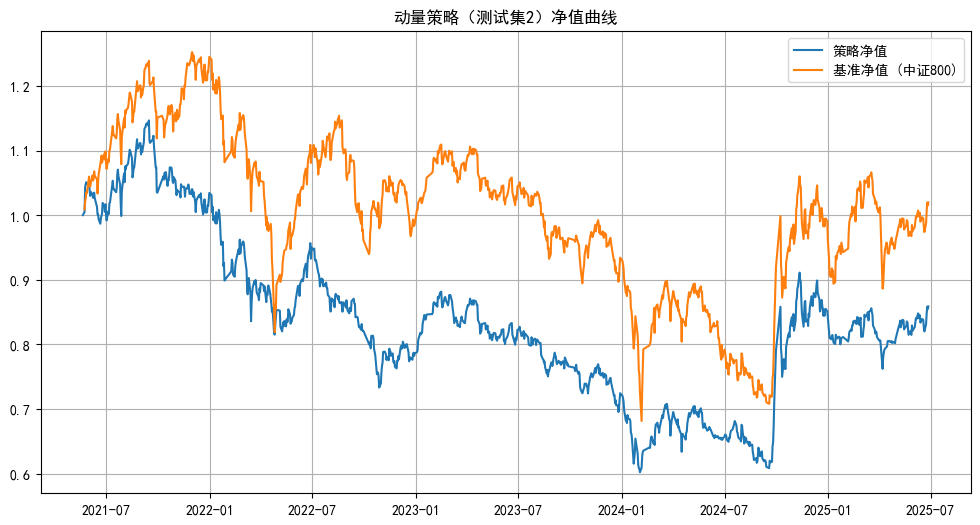

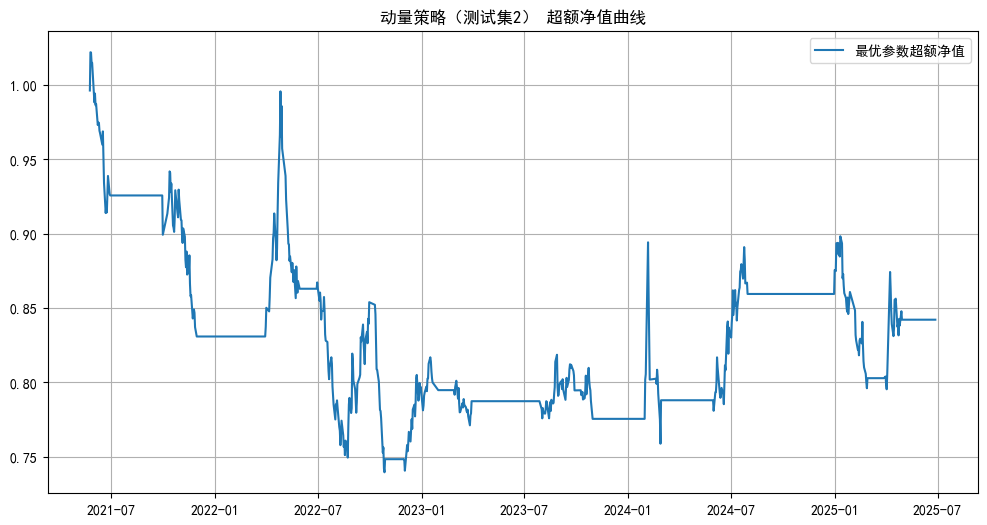

In [98]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test = (1 + returns_1000_test).cumprod()

# 计算超额净值曲线
excess_nav_test = portfolio_nav_test / benchmark_nav_test


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test.index, portfolio_nav_test, label='策略净值')
plt.plot(benchmark_nav_test.index, benchmark_nav_test, label='基准净值 (中证800)')
plt.title('动量策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test.index, excess_nav_test, label='最优参数超额净值')
plt.title('动量策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()


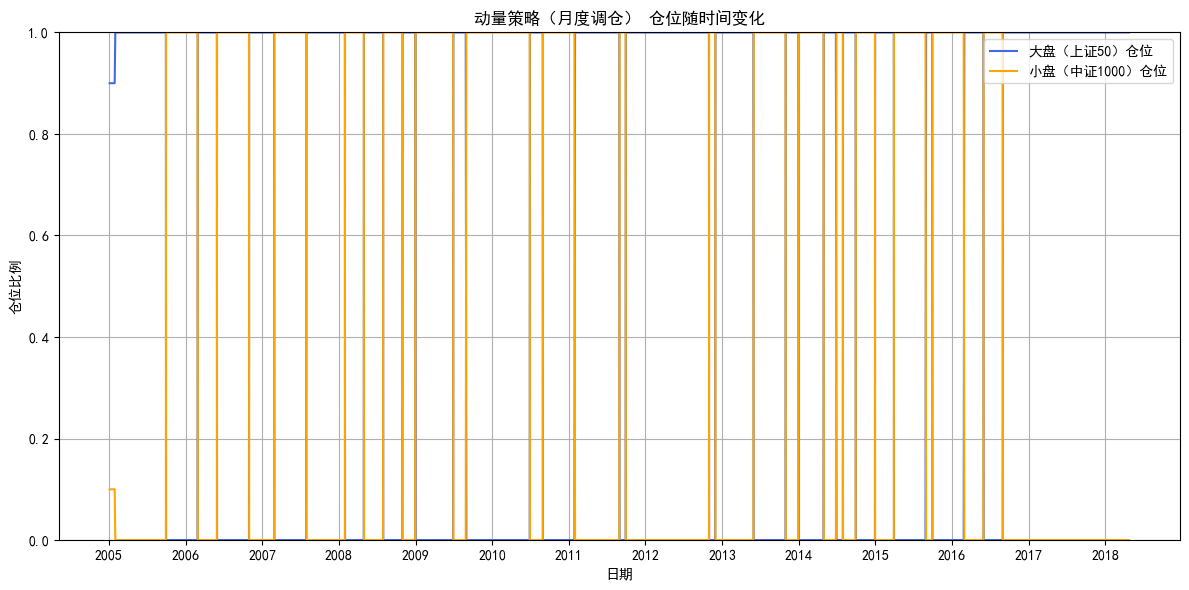

In [99]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

In [100]:
# 选取最优参数
best_params = results_df_sorted.iloc[0]

# 在测试集上运行策略
position_test = momentum_strategy_monthly(
    df_val,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    min_large_weight=best_params['min_large_weight']
)

returns_50_test = df_val['50收益'].pct_change()
returns_1000_test = df_val['中证1000全收益'].pct_change()
portfolio_returns_test = position_test['position_50'] * returns_50_test + position_test['position_1000'] * returns_1000_test
portfolio_returns_test = portfolio_returns_test.fillna(0)

portfolio_nav_test = (1 + portfolio_returns_test).cumprod()

# 计算测试集指标
annual_return_test = portfolio_nav_test.iloc[-1] ** (252 / len(portfolio_nav_test)) - 1
annual_vol_test = portfolio_returns_test.std() * np.sqrt(252)
sharpe_ratio_test = annual_return_test / annual_vol_test
max_drawdown_test = (portfolio_nav_test / portfolio_nav_test.cummax() - 1).min()
calmar_ratio_test = annual_return_test / abs(max_drawdown_test)

print("\n【测试集表现】")
print(f"年化收益率: {annual_return_test:.2%}")
print(f"年化波动率: {annual_vol_test:.2%}")
print(f"夏普比率: {sharpe_ratio_test:.2f}")
print(f"最大回撤: {max_drawdown_test:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test:.2f}")


【测试集表现】
年化收益率: 15.79%
年化波动率: 22.26%
夏普比率: 0.71
最大回撤: -19.62%
Calmar Ratio: 0.80


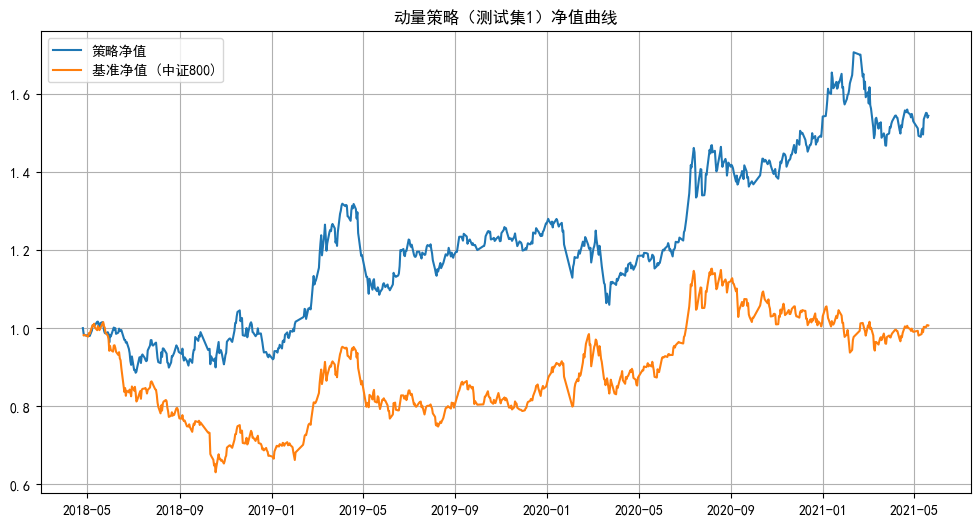

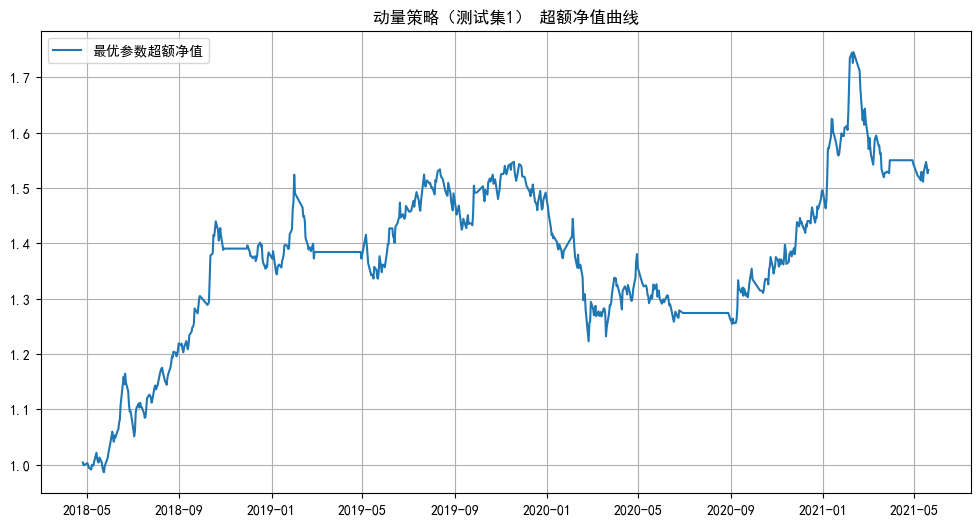

In [101]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test = (1 + returns_1000_test).cumprod()

# 计算超额净值曲线
excess_nav_test = portfolio_nav_test / benchmark_nav_test


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test.index, portfolio_nav_test, label='策略净值')
plt.plot(benchmark_nav_test.index, benchmark_nav_test, label='基准净值 (中证800)')
plt.title('动量策略（测试集1）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test.index, excess_nav_test, label='最优参数超额净值')
plt.title('动量策略（测试集1） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

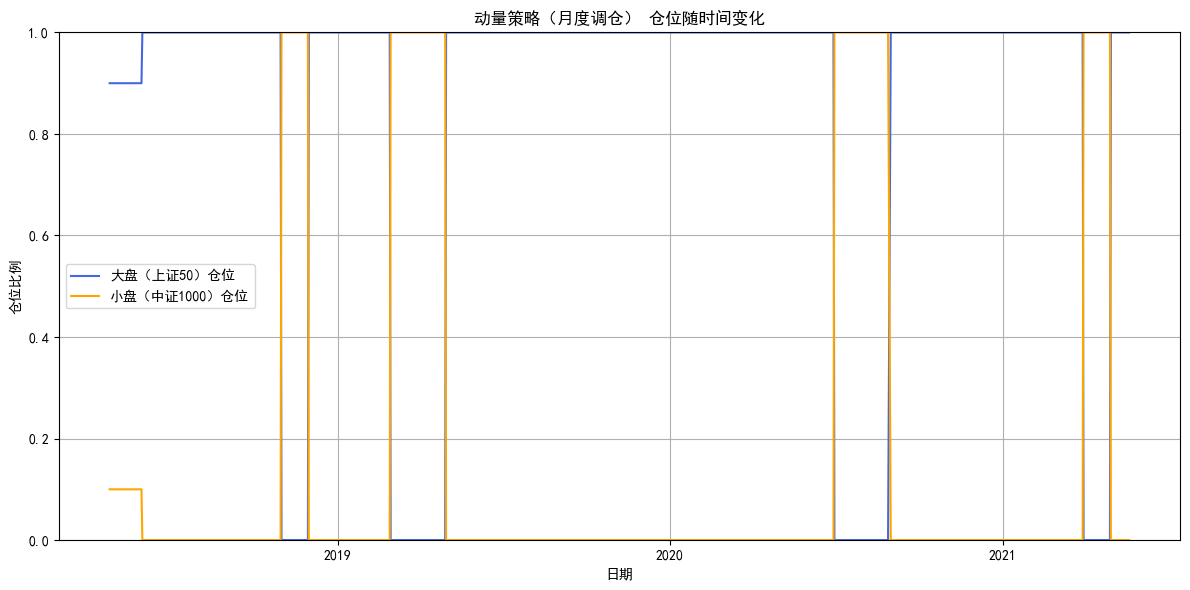

In [102]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_test.index, position_test['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_test.index, position_test['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

### 动量 + 反转 市场判断策略

In [103]:
def momentum_reversal_switch_strategy_monthly(df, window=20, threshold=0.015, min_large_weight=0.9, ma_window=120, slope_threshold=0.0005):
    """
    大小盘切换策略（月度调仓版本）：趋势市使用动量，震荡市使用反转

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算动量的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，震荡市反转策略使用的大盘最小配置比例
    - ma_window: int，均线斜率判断市场状态的窗口期
    - slope_threshold: float，均线斜率判断阈值（>threshold为趋势市，否则震荡市）

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算动量 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 计算均线及斜率 ===
    # 使用大盘小盘平均值作为市场指数
    market_index = (df['50收益'] + df['中证1000全收益']) / 2
    ma = market_index.rolling(ma_window).mean()
    ma_shifted = ma.shift(ma_window)
    slope = (ma - ma_shifted) / ma_window

    # === 3) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 4) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 5) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:

            # 判断市场状态
            if slope.loc[date] > slope_threshold:
                # 趋势市 ➔ 使用动量策略
                if (r_1000.loc[date] > r_50.loc[date] + threshold):
                    current_pos_50 = 0
                    current_pos_1000 = 1
                else:
                    current_pos_50 = 1
                    current_pos_1000 = 0

            else:
                # 震荡市 ➔ 使用反转策略（动量策略方向反转）
                if (r_1000.loc[date] > r_50.loc[date] + threshold):
                    current_pos_50 = 1
                    current_pos_1000 = 0
                else:
                    current_pos_50 = 0
                    current_pos_1000 = 1

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df


In [104]:
# 获取策略每日仓位
position_df = momentum_reversal_switch_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")


【回测指标】
年化收益率: 15.86%
年化波动率: 27.64%
夏普比率: 0.57
最大回撤: -58.65%
Calmar Ratio: 0.27


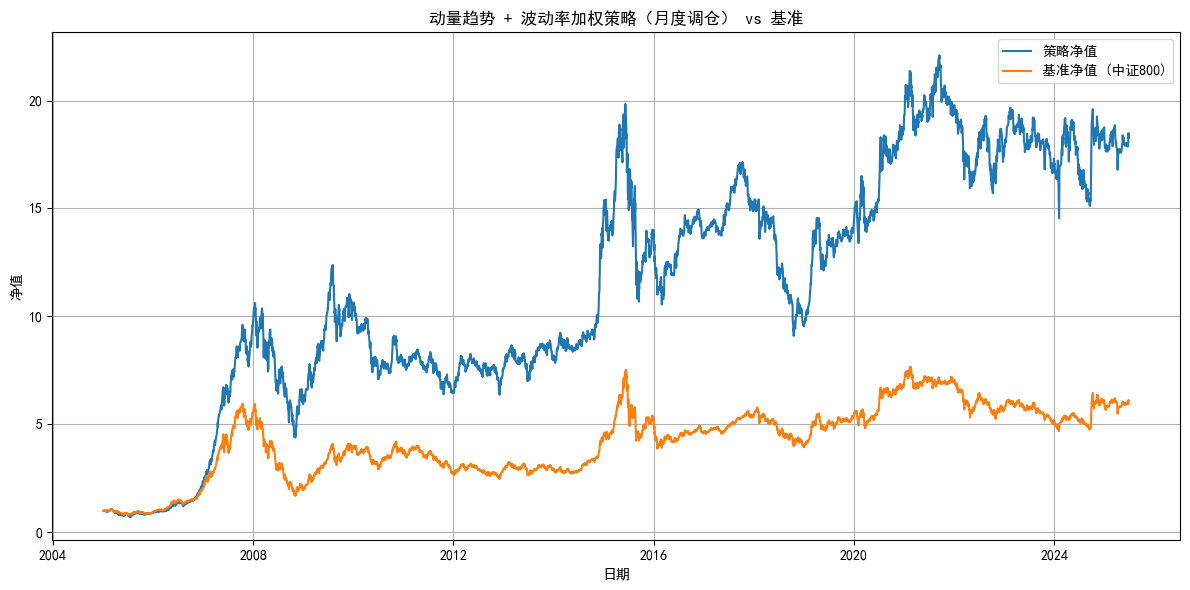

In [105]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量趋势 + 波动率加权策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

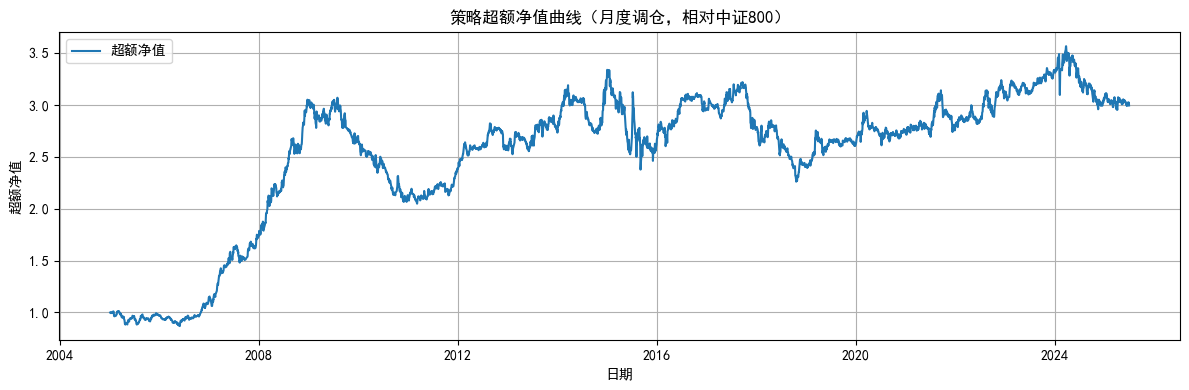

In [106]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（月度调仓，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

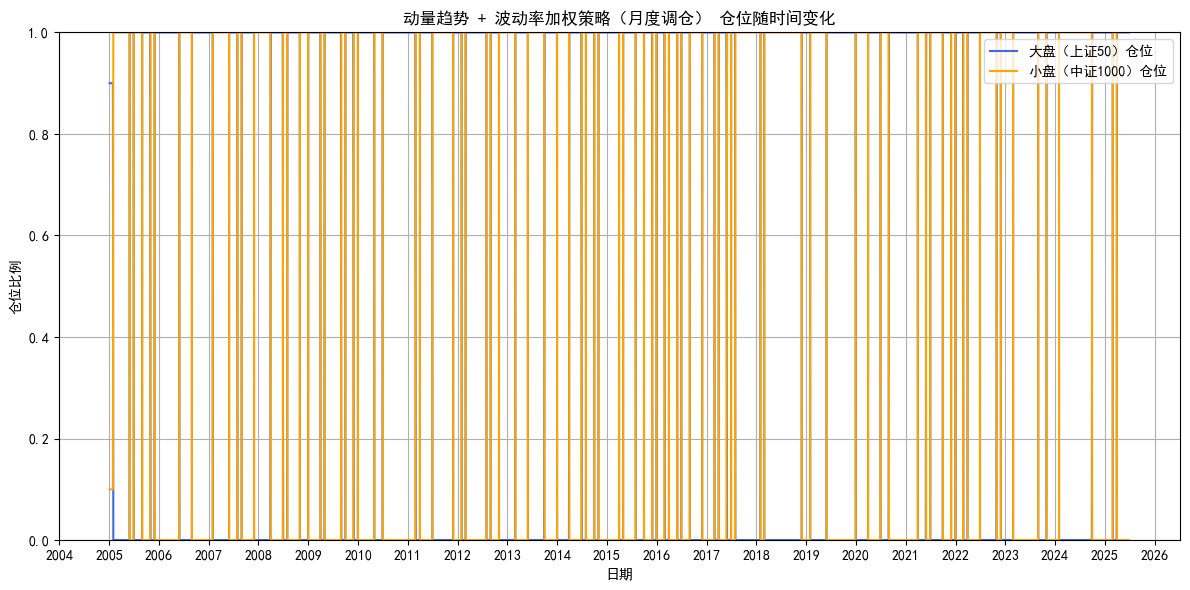

In [107]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量趋势 + 波动率加权策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

参数优化

In [108]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数范围
# =============================

window_range = [10, 20, 30, 40, 50, 60]
threshold_range = [0.0, 0.005, 0.01, 0.015, 0.02]
min_large_weight_range = [0.5, 0.6, 0.7, 0.8, 0.9]
ma_window_range = [30, 60, 120, 200]  # 均线窗口
slope_threshold_range = [0.0, 0.0005, 0.001, 0.002]  # 斜率阈值

# =============================
# Grid Search
# =============================

results = []

for window, threshold, min_large_weight, ma_window, slope_threshold in itertools.product(
        window_range, threshold_range, min_large_weight_range, ma_window_range, slope_threshold_range):
    
    # 获取策略仓位（在训练集上）
    position_df = momentum_reversal_switch_strategy_monthly(
        df_train,
        window=window,
        threshold=threshold,
        min_large_weight=min_large_weight,
        ma_window=ma_window,
        slope_threshold=slope_threshold
    )
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'threshold': threshold,
        'min_large_weight': min_large_weight,
        'ma_window': ma_window,
        'slope_threshold': slope_threshold,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
     window  threshold  min_large_weight  ma_window  slope_threshold  \
713      20      0.015               0.9        120           0.0005   
715      20      0.015               0.9        120           0.0020   
712      20      0.015               0.9        120           0.0000   
714      20      0.015               0.9        120           0.0010   
696      20      0.015               0.8        120           0.0000   
698      20      0.015               0.8        120           0.0010   
699      20      0.015               0.8        120           0.0020   
697      20      0.015               0.8        120           0.0005   
682      20      0.015               0.7        120           0.0010   
683      20      0.015               0.7        120           0.0020   

     annual_return  annual_vol  sharpe_ratio  max_drawdown  calmar_ratio  
713       0.230868    0.301520      0.765680     -0.586513      0.393628  
715       0.230868   

In [109]:
# =============================
# 选取最优参数
# =============================

best_params = results_df_sorted.iloc[0]

# =============================
# 在验证集 (测试集1) 上运行策略
# =============================

position_val = momentum_reversal_switch_strategy_monthly(
    df_val,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    min_large_weight=best_params['min_large_weight'],
    ma_window=int(best_params['ma_window']),
    slope_threshold=best_params['slope_threshold']
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)

portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

# =============================
# 计算验证集指标
# =============================

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 11.67%
年化波动率: 24.01%
夏普比率: 0.49
最大回撤: -36.52%
Calmar Ratio: 0.32


In [110]:
position_test2 = momentum_reversal_switch_strategy_monthly(
    df_test,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    min_large_weight=best_params['min_large_weight'],
    ma_window=int(best_params['ma_window']),
    slope_threshold=best_params['slope_threshold']
)

returns_50_test2 = df_test['50收益'].pct_change()
returns_1000_test2 = df_test['中证1000全收益'].pct_change()
portfolio_returns_test2 = position_test2['position_50'] * returns_50_test2 + position_test2['position_1000'] * returns_1000_test2
portfolio_returns_test2 = portfolio_returns_test2.fillna(0)

portfolio_nav_test2 = (1 + portfolio_returns_test2).cumprod()

# =============================
# 计算测试集2指标
# =============================

annual_return_test2 = portfolio_nav_test2.iloc[-1] ** (252 / len(portfolio_nav_test2)) - 1
annual_vol_test2 = portfolio_returns_test2.std() * np.sqrt(252)
sharpe_ratio_test2 = annual_return_test2 / annual_vol_test2
max_drawdown_test2 = (portfolio_nav_test2 / portfolio_nav_test2.cummax() - 1).min()
calmar_ratio_test2 = annual_return_test2 / abs(max_drawdown_test2)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test2:.2%}")
print(f"年化波动率: {annual_vol_test2:.2%}")
print(f"夏普比率: {sharpe_ratio_test2:.2f}")
print(f"最大回撤: {max_drawdown_test2:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test2:.2f}")


【测试集2（最终测试集）表现】
年化收益率: 0.99%
年化波动率: 22.05%
夏普比率: 0.04
最大回撤: -34.52%
Calmar Ratio: 0.03


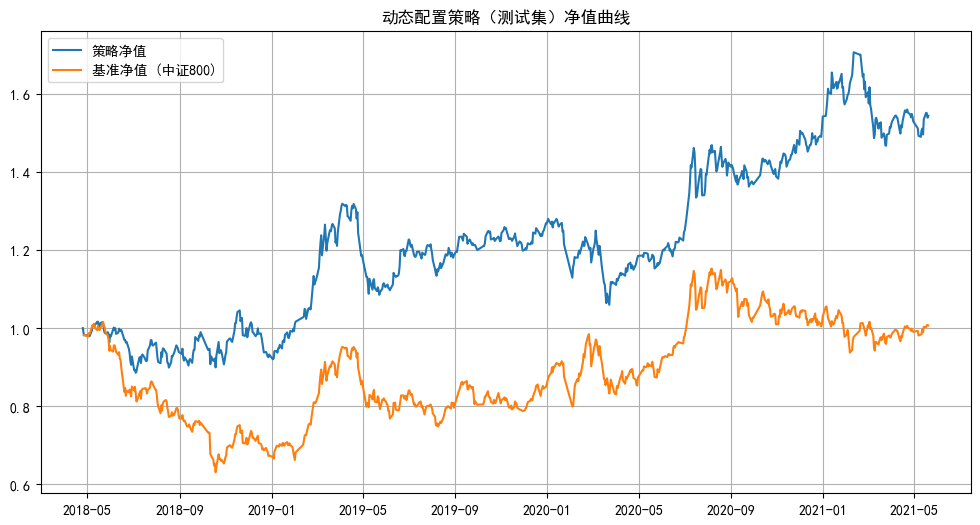

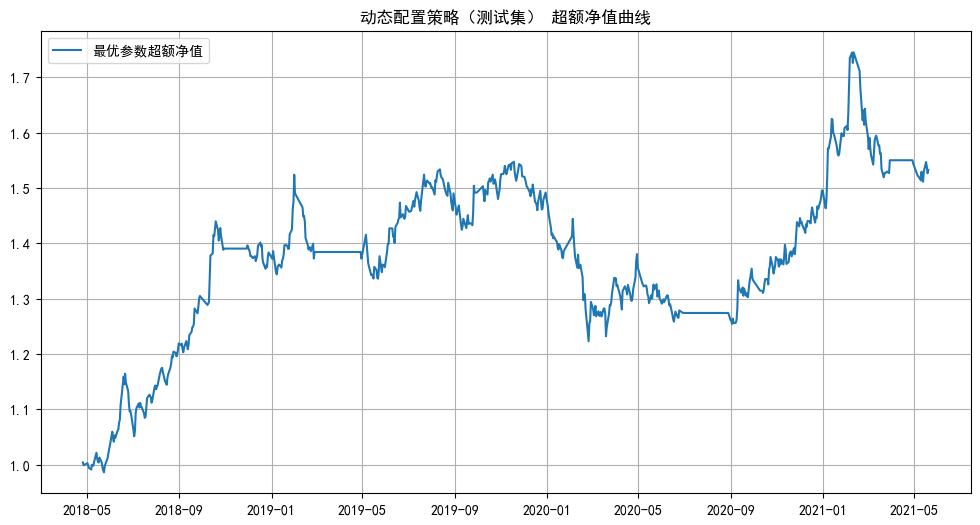

In [111]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test = (1 + returns_1000_test).cumprod()

# 计算超额净值曲线
excess_nav_test = portfolio_nav_test / benchmark_nav_test


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test.index, portfolio_nav_test, label='策略净值')
plt.plot(benchmark_nav_test.index, benchmark_nav_test, label='基准净值 (中证800)')
plt.title('动态配置策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test.index, excess_nav_test, label='最优参数超额净值')
plt.title('动态配置策略（测试集） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

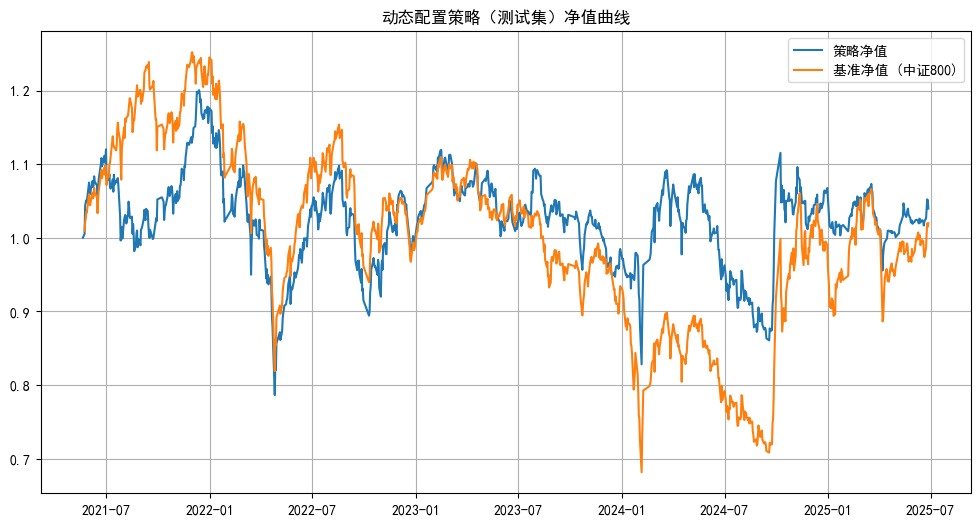

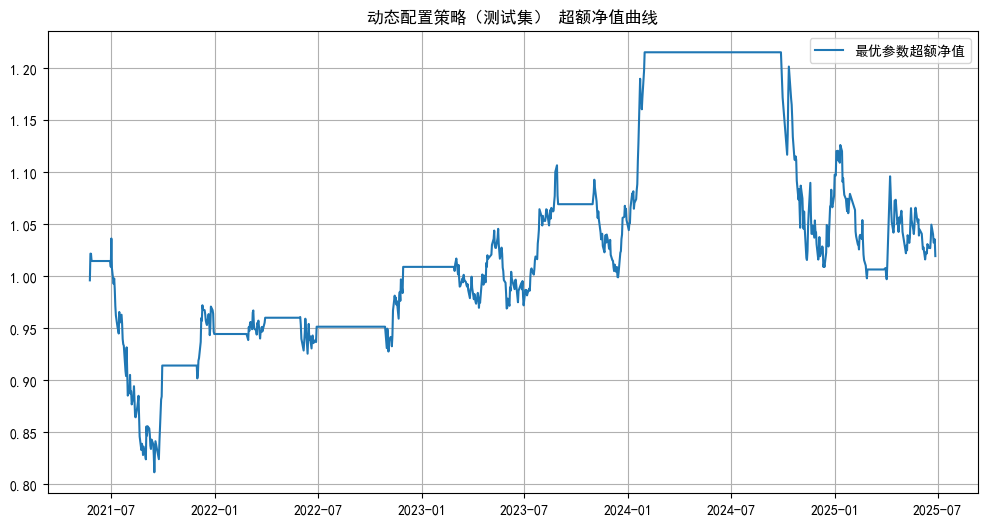

In [112]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test2 = (1 + returns_1000_test2).cumprod()

# 计算超额净值曲线
excess_nav_test2 = portfolio_nav_test2 / benchmark_nav_test2


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test2.index, portfolio_nav_test2, label='策略净值')
plt.plot(benchmark_nav_test2.index, benchmark_nav_test2, label='基准净值 (中证800)')
plt.title('动态配置策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test2.index, excess_nav_test2, label='最优参数超额净值')
plt.title('动态配置策略（测试集） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

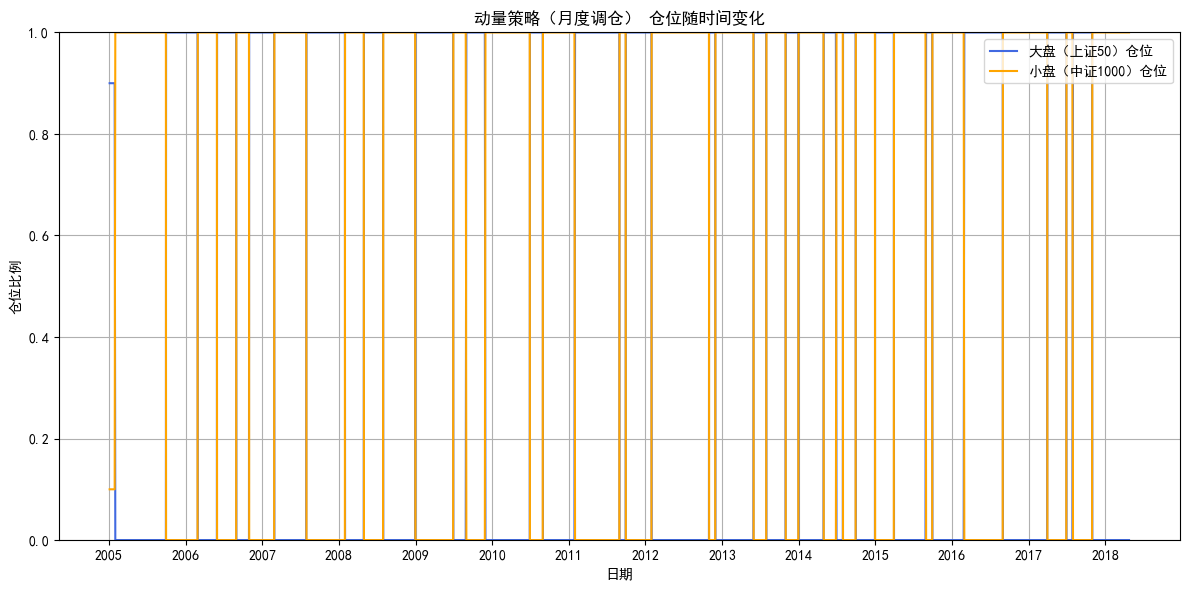

In [113]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()